## Example: Single Index Models and Minimum Variance Portfolio Allocation
In this example, we will use single index models to construct a minimum variance portfolio from a set of risky assets. 

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> Three learning objectives here.

Let's get stared!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `09-26-2025`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [2]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 482 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow; # maximum number of trading days in our dataset

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [5]:
list_of_tickers = keys(dataset) |> collect |> sort;

Next, we'll compute the growth rate matrix for all firms in the dataset. We've implemented [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix) which takes the cleaned dataset and a list of ticker symbols, and returns the growth rate array. Each row of the growth rate array is a time step, while each column corresponds to a firm from the `list_of_tickers::Array{String,1}` array.

We'll save this data in the `growth_rate_array::Array{Float64,2}` variable:

In [6]:
growth_rate_array = let

    # initialize -
    r̄ = 0.0; # assume the risk-free rate is 0
    Δt = 1.0/252.0; # assume daily trading (252 trading days in a year)

    # compute the growth matrix -
    growth_rate_array = log_growth_matrix(dataset, list_of_tickers, Δt = Δt, 
        risk_free_rate = r̄); # other optional parameters are at their defaults

    growth_rate_array; # return
end;

Next, let's load the covariance matrix that we computed in the previous example:

In [7]:
covariance_dictionary = let

    # initialize -
    path_to_covariance = joinpath(_PATH_TO_DATA,"Covariance-Return-Training-Fall-2025.jld2");
    covariance = JLD2.load(path_to_covariance);
    covariance;
end;

Fill me in

In [8]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

Finally, let's load up the single index model parameters that we computed in the previous example.

In [9]:
sim_model_parameters = let

    # initialize -
    path_to_sim_model_parameters = joinpath(_PATH_TO_DATA,"SIMs-SP500-01-03-14-to-12-31-24.jld2");
    sim_model_parameters = JLD2.load(path_to_sim_model_parameters);
    sim_model_parameters["data"]; # return
end;

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [10]:
risk_free_rate = 0.0389; # hypothetical continuous compounded risk free rate (units: 1/year)
Δt = (1.0/252.0); # time step for 1-trading day (units: 1/year)

___

## Task 1: Setup Risk and Return Matrices
In this task, we will set up the risk and return matrices that we will use in the minimum variance portfolio allocation. We'll do two versions: one using a pure data driven approach and another using the single index model parameters.

Let's start by specifying a collection of ticker symbols, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers::Array{String,1}` array.

In [11]:
my_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD", "NVDA", "GS", "BAC", "WFC", "C", "F", "GM", "JNJ"]; # random tickers that I selected.

### Data-Driven Risk and Return Matrices
Now that we have selected the firms in our risky portfolio, we'll compute the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. 

In [12]:
μ̂_data, Σ̂_data = let

    # initialize -
    M = length(my_list_of_tickers); # number of assets in portfolio
    μ = Array{Float64,1}(); # drift vector
    Σᵣ = Array{Float64,2}(undef, M, M); # covariance matrix for *our* portfolio
    tickers_in_parameters = parameters_df[:, :ticker] |> collect; # list of tickers in parameters_df
    covariance_ticker_list = covariance_dictionary["list_of_tickers"] |> collect; # list of tickers in covariance dictionary
    Σ = covariance_dictionary["covariance_matrix"]; # full covariance matrix

    # compute drift vector -
    for ticker ∈ my_list_of_tickers
        i = findfirst(x-> x == ticker, tickers_in_parameters); # find index of ticker in the parameters_df
        push!(μ, parameters_df[i, :drift]); # append drift value to μ
    end

    # compute covariance matrix -
    for i ∈ 1:M
        for j ∈ 1:M
            row_index = findfirst(x-> x == my_list_of_tickers[i], covariance_ticker_list); # find row index in full covariance matrix
            col_index = findfirst(x-> x == my_list_of_tickers[j], covariance_ticker_list); # find column index in full covariance matrix
            Σᵣ[i,j] = Σ[row_index, col_index]; # assign value to Σᵣ
        end
    end

    (μ, Σᵣ); # return
end;

Next, we need to pull out the growth rate of the market portfolio from `growth_rate_array::Array{Float64,2}`. To do this, look up the index for our market portfolio surrogate `SPY`, then store the growth rate (column from the growth rate array) in the `Gₘ::Array{Float64,1}` variable:

In [13]:
Gₘ = findfirst(x->x=="SPY", list_of_tickers) |> i -> growth_rate_array[:,i];

### Compute the expected returns using single index models
Fill me in.

In [14]:
sim_model_parameters["AAPL"]

(ticker = "AAPL", n = 2766, p = 2, t = 1.96, alpha = 0.10605520914187137, beta = 1.1945864028660338, alpha_SE = 0.05142331293781634, beta_SE = 0.023948874510820575, alpha_95_CI_lower = 0.005265515783751354, alpha_95_CI_upper = 0.20684490249999138, beta_95_CI_lower = 1.1476466088248254, beta_95_CI_upper = 1.2415261969072422, training_variance = 1838.7010778838012)

In [15]:
μ̂_sim, Σ̂_sim = let

    # initialize -
    N = length(my_list_of_tickers); # number of assets in portfolio
    μ_sim = Array{Float64,1}(); # drift vector
    Σ̂_sim = Array{Float64,2}(undef, N, N); # covariance matrix for *our* portfolio
    Ḡₘ = mean(Gₘ); # average market factor -
    σ²ₘ = var(Gₘ); # variance of market factor

    # compute the expected growth rate (return) for each of our tickers -
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        data = sim_model_parameters[ticker]; # get the data for this ticker
        αᵢ = data.alpha; # get alpha
        βᵢ = data.beta; # get beta
        Ḡᵢ = αᵢ + βᵢ* Ḡₘ; # compute the growth rate for this ticker
        push!(μ_sim, Ḡᵢ); # append drift value to μ_sim
    end

    # compute the covariance matrix using the single index model -
    for i ∈ eachindex(my_list_of_tickers)

        ticker_i = my_list_of_tickers[i];
        data_i = sim_model_parameters[ticker_i]; # get the data for ticker i
        βᵢ = data_i.beta; # get beta for ticker i
        σ²_εᵢ = (Δt)*data_i.training_variance; # residual variance for ticker i

        for j ∈ eachindex(my_list_of_tickers)
            
            ticker_j = my_list_of_tickers[j];
            data_j = sim_model_parameters[ticker_j]; # get the data for ticker j
            βⱼ = data_j.beta; # get beta for ticker j
            σ²_εⱼ = (Δt)*data_j.training_variance; # residual variance for ticker j
            
            if i == j
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ + σ²_εᵢ; # diagonal elements
            else
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ; # off-diagonal elements
            end
        end
    end

    (μ_sim, Σ̂_sim*Δt); # return
end;

In [16]:
Σ̂_sim

13×13 Matrix{Float64}:
 0.061982   0.0318509  0.0327428  …  0.039635   0.0406288  0.0149176
 0.0318509  0.0529216  0.0315759     0.0382225  0.0391808  0.014386
 0.0327428  0.0315759  0.0934778     0.0392928  0.040278   0.0147888
 0.0468707  0.0452003  0.046466      0.0562469  0.0576572  0.02117
 0.048084   0.0463704  0.0476689     0.057703   0.0591498  0.021718
 0.0483635  0.0466399  0.0479459  …  0.0580383  0.0594936  0.0218442
 0.036219   0.0349283  0.0359063     0.0434645  0.0445543  0.016359
 0.0375853  0.0362458  0.0372608     0.045104   0.0462349  0.0169761
 0.0342366  0.0330165  0.033941      0.0410855  0.0421156  0.0154636
 0.0414928  0.0400141  0.0411346     0.0497933  0.0510417  0.018741
 0.039635   0.0382225  0.0392928  …  0.11332    0.0487563  0.0179018
 0.0406288  0.0391808  0.040278      0.0487563  0.113855   0.0183507
 0.0149176  0.014386   0.0147888     0.0179018  0.0183507  0.0250658

In [17]:
Σ̂_data

13×13 Matrix{Float64}:
 0.054998   0.0301101  0.02693     …  0.024752   0.0256372  0.0102411
 0.0301101  0.0464282  0.028659       0.021397   0.0220835  0.0101588
 0.02693    0.028659   0.086602       0.0300845  0.0332688  0.00955275
 0.0386414  0.0364987  0.0564706      0.0487509  0.0512663  0.00885736
 0.0418636  0.0405472  0.0461653      0.0421099  0.042669   0.00937637
 0.0457208  0.0463697  0.0465067   …  0.0415535  0.0436856  0.0067175
 0.0228452  0.0215869  0.0289937      0.0437096  0.0473049  0.011942
 0.0216485  0.0204548  0.0284563      0.0474835  0.051084   0.0124359
 0.0179128  0.0176504  0.0261185      0.0445623  0.0461418  0.0120416
 0.0251574  0.0231297  0.0323765      0.0531001  0.0565119  0.0128019
 0.024752   0.021397   0.0300845   …  0.103253   0.0784669  0.011166
 0.0256372  0.0220835  0.0332688      0.0784669  0.10328    0.010851
 0.0102411  0.0101588  0.00955275     0.011166   0.010851   0.0236365

## Task 2: Compute thedata-driven efficient frontier for your collection of tickers
Now, we can compute the data-driven and single index model efficient frontiers, assuming only risky assets. To begin, create an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Store this in the `problem_risk` variable. 

You'll need to pass your covariance array $\hat{\Sigma}_{\star}$, the expected return array $\hat{\mu}_{\star}$, along with bounds and an initial guess, to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Start by setting up the bounds and constants in the problem:

In [18]:
number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
number_of_points = 50;

Build an instance of the [MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem) using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem},%20NamedTuple}) for the `data` version of the problem:

In [19]:
problem_data = build(MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem, (
    Σ = Σ̂_data, # data cov matrix
    μ = μ̂_data, # data expected return
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

and the `single index model` version of the problem (store the single index version of the problem in the `problem_risk_sim` variable):

In [20]:
problem_sim = build(MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem, (
    Σ = Σ̂_sim, # sim cov matrix
    μ = μ̂_sim, # sim expected array
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, we create an array with the minimum desired rewards (the calculation must achieve at least this much reward). In this case, assume we go from `0` to `10`$\times{r_{f}}$ and take `number_of_points` steps.  We store these values in the `minimum_desired_reward_array` variable:

In [21]:
minimum_desired_reward_array = range(0.0, stop = 20*risk_free_rate, length = number_of_points) |> collect; # excess return from zero

We now iterate through the `minimum_desired_reward_array::Array{Float64,1}` and compute the minimum risk required to achieve the specified reward level using a `for-loop`.

For each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk as the `key` and the expected return, risk and allocation as the `value` in the `efficient_frontier` dictionary.

Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [22]:
efficient_frontier_data = let

    # initialize -
    efficient_frontier = Dict{Float64, NamedTuple}();

    # main loop
    for i ∈ eachindex(minimum_desired_reward_array)
        problem_data.R = minimum_desired_reward_array[i]; # update the problem object with the min desired reward value
    
        try
            solution = solve(problem_data)
            status_flag = solution["status"];    

            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                risk_value = solution["objective_value"]; # get the sqrt of the risk -
                reward_value = solution["reward"];
                allocation = solution["argmax"]; # TODO: need to update this key
                efficient_frontier[risk_value] = (risk = risk_value, reward = reward_value, w = allocation)
            end
        catch err
            # Uncomment to see which R's failed ...
            # println("Failed: desired R = $(problem_risk.R). Infeasible");
        end    
    end
    efficient_frontier;
end;

Let's now do the same thing for the single index model case, where we store the results in the `efficient_frontier_sim` dictionary:

In [23]:
efficient_frontier_sim = let

    # initialize -
    efficient_frontier = Dict{Float64, NamedTuple}();

    # main loop
    for i ∈ eachindex(minimum_desired_reward_array)
        problem_sim.R = minimum_desired_reward_array[i]; # update the problem object with the min desired reward value
    
        try
            solution = solve(problem_sim)
            status_flag = solution["status"];    

            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                risk_value = solution["objective_value"]; # get the sqrt of the risk -
                reward_value = solution["reward"];
                allocation = solution["argmax"]; # TODO: need to update this key
                efficient_frontier[risk_value] = (risk = risk_value, reward = reward_value, w = allocation)
            end
        catch err
            # Uncomment to see which R's failed ...
            # println("Failed: desired R = $(problem_sim.R). Infeasible");
        end    
    end
    efficient_frontier;
end;

In [24]:
efficient_frontier_sim

Dict{Float64, NamedTuple} with 39 entries:
  0.0221388 => (risk = 0.0221388, reward = 0.111145, w = [0.0797735, 0.135475, …
  0.088726  => (risk = 0.088726, reward = 0.476327, w = [0.184312, 0.187243, 2.…
  0.0221358 => (risk = 0.0221358, reward = 0.108815, w = [0.074737, 0.129501, 0…
  0.0221358 => (risk = 0.0221358, reward = 0.108815, w = [0.0747371, 0.129501, …
  0.070613  => (risk = 0.070613, reward = 0.428694, w = [0.240217, 0.284007, 2.…
  0.0400096 => (risk = 0.0400096, reward = 0.301673, w = [0.231231, 0.302008, 6…
  0.129347  => (risk = 0.129347, reward = 0.555714, w = [0.0911362, 0.0259704, …
  0.111534  => (risk = 0.111534, reward = 0.523959, w = [0.128407, 0.0904792, 9…
  0.0656185 => (risk = 0.0656185, reward = 0.412816, w = [0.258852, 0.316261, 3…
  0.0285628 => (risk = 0.0285628, reward = 0.222286, w = [0.189426, 0.258904, 1…
  0.0372711 => (risk = 0.0372711, reward = 0.285796, w = [0.223263, 0.293864, 7…
  0.0495692 => (risk = 0.0495692, reward = 0.349306, w = [0.255135

### Organize efficient frontier results into a matrix for analysis and visualization
Transform the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary into a matrix format for plotting and analysis.

> __What are we doing?__ Extract portfolio data from the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary and organize it into the `results_array_data::Array{Float64,2}` matrix. Sort portfolios by risk level and store risk, return, and allocation weights in matrix columns.

> __What's in the results array?__ The `results_array_data::Array{Float64,2}` has `number_of_portfolios::Int64` rows and `M+2` columns:
> * Column 1: Portfolio risk (standard deviation = √variance)  
> * Column 2: Portfolio expected return
> * Columns 3 to M+2: Asset allocation weights for the `M::Int64` tickers

Let's build the `results_array_data::Array{Float64,2}` from our efficient frontier solutions:

In [25]:
results_array_data = let

    # initialize -
    efficient_frontier = efficient_frontier_data; # use the data efficient frontier
    number_of_portfolios = length(efficient_frontier); # how many portfolios do we have? (these all exited correctly)
    M = length(my_list_of_tickers); # how many tickers do we have?
    results_array = Array{Float64,2}(undef, number_of_portfolios, M+2);
    risk_array_sorted = keys(efficient_frontier) |> collect |> sort;

    for i ∈ eachindex(risk_array_sorted)
        risk_value = risk_array_sorted[i] |> sqrt; # let's plot the sqrt of the risk
        
        data = efficient_frontier[risk_array_sorted[i]] # get the NamedTuple corresponding to this risk level
        reward_value = data.reward;
        w = data.w;

        results_array[i,1] = risk_value;
        results_array[i,2] = reward_value;
        for j ∈ 1:M
            results_array[i,2+j] = w[j];
        end
    end

    results_array
end

32×15 Matrix{Float64}:
 0.137008  0.0924052  0.0901422   0.14233    …   0.00205482   0.627754
 0.137008  0.0924051  0.0901419   0.14233        0.00205821   0.627754
 0.137008  0.0924051  0.0901419   0.142329       0.00205825   0.627755
 0.137008  0.0924051  0.0901419   0.142329       0.00205862   0.627755
 0.137008  0.0924051  0.0901418   0.142329       0.00205868   0.627755
 0.137008  0.0924051  0.0901418   0.142329   …   0.00205895   0.627755
 0.137025  0.0952661  0.0943575   0.1493         0.00223508   0.623201
 0.137651  0.111143   0.108065    0.171721       0.00152487   0.607991
 0.139012  0.12702    0.116406    0.187789       1.12485e-7   0.595576
 0.141208  0.142898   0.124862    0.201896       8.11335e-7   0.570508
 ⋮                                           ⋱               
 0.257562  0.365184   0.188765    0.330563       2.66248e-8   4.17189e-7
 0.270192  0.381061   0.162068    0.294335       2.10661e-8   1.46564e-7
 0.283564  0.396939   0.13537     0.258107   …   1.70169e-8

in a similar manner, we can build the `results_array_sim::Array{Float64,2}` from our single index model efficient frontier solutions:

In [26]:
results_array_sim = let

    # initialize -
    efficient_frontier = efficient_frontier_sim; # use the SIM efficient frontier
    number_of_portfolios = length(efficient_frontier); # how many portfolios do we have? (these all exited correctly)
    M = length(my_list_of_tickers); # how many tickers do we have?
    results_array = Array{Float64,2}(undef, number_of_portfolios, M+2);
    risk_array_sorted = keys(efficient_frontier) |> collect |> sort;

    for i ∈ eachindex(risk_array_sorted)
        risk_value = risk_array_sorted[i] |> sqrt; # let's plot the sqrt of the risk
        
        data = efficient_frontier[risk_array_sorted[i]] # get the NamedTuple corresponding to this risk level
        reward_value = data.reward;
        w = data.w;

        results_array[i,1] = risk_value;
        results_array[i,2] = reward_value;
        for j ∈ 1:M
            results_array[i,2+j] = w[j];
        end
    end

    results_array
end

39×15 Matrix{Float64}:
 0.148781  0.108815  0.074737    0.129501    …   5.05167e-7   0.715582
 0.148781  0.108815  0.074737    0.129501        5.05167e-7   0.715582
 0.148781  0.108815  0.074737    0.129501        5.05168e-7   0.715582
 0.148781  0.108815  0.074737    0.129501        5.0517e-7    0.715582
 0.148781  0.108815  0.0747371   0.129501        5.05173e-7   0.715582
 0.148781  0.108815  0.0747371   0.129501    …   5.05179e-7   0.715582
 0.148781  0.108815  0.0747373   0.129502        5.05197e-7   0.715582
 0.148791  0.111145  0.0797735   0.135475        4.81966e-7   0.710529
 0.149392  0.12702   0.114091    0.176181        4.86805e-9   0.676106
 0.150912  0.142898  0.144468    0.211975        2.80673e-7   0.639884
 ⋮                                           ⋱               
 0.297869  0.476327  0.184312    0.187243    …   3.03397e-8   1.62359e-7
 0.309527  0.492204  0.165677    0.154989       -8.9992e-9   -7.7796e-9
 0.321573  0.508082  0.147042    0.122734        1.32579e-8 

### Visualize the efficient frontier
Now that we have computed the optimal portfolios, let's visualize the classic risk-return trade-off that Markowitz theory reveals. The efficient frontier shows the boundary of achievable risk-return combinations for our selected assets.

`Unhide` the code block below to see how we plotted the efficient frontier for the collection of equities and ETFs specified in the `my_list_of_tickers::Array{String,1}` array.

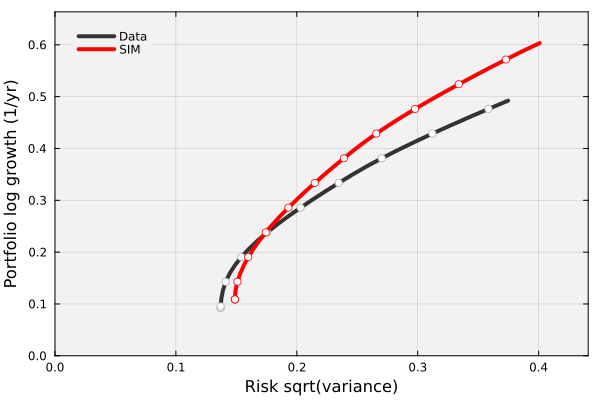

In [27]:
let

    # initialize -
    max_risk_value = results_array_data[end,1]; # what is the biggest risk we have (x-axis value)
    max_reward_value = results_array_data[end,2]; # what is the biggest reward that we have (y-axis value)
    number_of_portfolios_data = length(efficient_frontier_data); # how many portfolios did we recover?
    skip = 3;

    plot(results_array_data[:,1], results_array_data[:,2], lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=18, label="Data", c=:gray20, 
        xlim=(0.0, 1.1*max_risk_value), ylim = (0.0, 1.1*max_reward_value))
    scatter!(results_array_data[1:skip:number_of_portfolios_data,1], results_array_data[1:skip:number_of_portfolios_data,2], 
        label="", c=:white, ms=4, msc=:gray69)

    max_risk_value = results_array_sim[end,1]; # what is the biggest risk we have (x-axis value)
    max_reward_value = results_array_sim[end,2]; # what is the biggest reward that we have (y-axis value)
    number_of_portfolios_sim = length(efficient_frontier_sim); # how many portfolios did we recover?
    plot!(results_array_sim[:,1], results_array_sim[:,2], lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=18, label="SIM", c=:red, 
        xlim=(0.0, 1.1*max_risk_value), ylim = (0.0, 1.1*max_reward_value))
    scatter!(results_array_sim[1:skip:number_of_portfolios_sim,1], results_array_sim[1:skip:number_of_portfolios_sim,2], 
        label="", c=:white, ms=4, msc=:red)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);

end

## Task 3: What's in a data-driven versus single index model portfolio?
The single index model efficient frontier is shifted to the left compared with the data-driven portfolio. Let's explore how this left shift is reflected in the choices of the weights of the assets in the portfolio. To begin, specify a desired portfolio growth rate in the `desired_growth_rate` variable:

In [50]:
desired_growth_rate = 0.10; # select a desired *excess* return where both approaches have data

Next, let's resolve the minimum variance problem for the data-driven and single-index models, assuming a `desired_growth_rate` value. Update the `problem_risk` and `problem_risk_sim` problem instances with the new `R` field:

and solve the minimum-variance allocation problem for both versions of the problem instance:

In [51]:
solution_data, solution_sim = let

    # initialize -
    problem_data.R = desired_growth_rate;
    problem_sim.R = desired_growth_rate;
    solution_data = nothing;
    solution_sim = nothing;
    
    try
        solution_data = solve(problem_data);
        solution_sim = solve(problem_sim);
    catch err
        # uncoment below to see error message
        println("What the what? Something happened: $(err)");
    end

    (solution_data, solution_sim); # return
end;

`Unhide` the code block below to see how we constructed the portfolio allocation table for the data-driven and single-index model portfolios.

__Summary__: The data-driven and single-index model allocations are similar, where each non-zero allocation for the data-driven portfolio is preserved in the case of the single-index model. However, several minor differences between the two portfolios do not appear to be correlated with the $\beta$ of the ticker. 

In [52]:
let
    ω_data = solution_data["argmax"];
    ω_sim = solution_sim["argmax"];
    table_df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        ω_dataᵢ = ω_data[i];
        ω_simᵢ = ω_sim[i];
        row_data = (
            ticker = ticker,
            α = sim_model_parameters[ticker].alpha,
            β = sim_model_parameters[ticker].beta,
            w_data = round(ω_dataᵢ, digits=4) |> abs,
            w_sim = round(ω_simᵢ, digits=4) |> abs,
            Δ_percentage = isapprox(ω_dataᵢ,0.0, atol=1e-2) ? 0.0 : ((ω_simᵢ - ω_dataᵢ)/(ω_dataᵢ))*100
        );
        push!(table_df,row_data)
    end

    
    pretty_table(table_df, backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- ------------ ---------- --------- --------- --------------
  ticker            α          β    w_data     w_sim   Δ_percentage 
  String      Float64    Float64   Float64   Float64        Float64 
 -------- ------------ ---------- --------- --------- --------------
    AAPL     0.106055    1.19459    0.1012    0.0747         -26.16
    MSFT    0.0999256    1.15201    0.1606    0.1295       -19.3805
    INTC    -0.148435    1.18427     0.031    0.0383        23.3697
      MU    -0.053226    1.69527       0.0       0.0            0.0
     AMD     0.127466    1.73915       0.0       0.0            0.0
    NVDA      0.34678    1.74926    0.0002       0.0            0.0
      GS   -0.0325528    1.31001    0.0323    0.0081       -74.9457
     BAC   -0.0545152    1.35942       0.0       0.0            0.0
     WFC   -0.0914062     1.2383    0.0492    0.0338       -31.3513
       C    -0.133436    1.50075       0.0       0.0            0.0
       F    -0.192761    1.43356    0.0072  

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.